Day3　ver1.2

+ Day2に続き各種の異常検出手法を適用し、気温、風速、全天日射量、湿度を計測可能なデータとし、基本的な手法を用いて日射病予防となるような異常気象を検出する。

+ データの性質上手法が最適でない場合も含めまずは各種の異常検出手法を実践する。

# 混合正規分布

* 確率密度関数  
$\displaystyle f({\boldsymbol \mu},{\Sigma}  )=\frac{1}{(\sqrt{2 \pi })^p \sqrt{\left| \Sigma \right| }}exp\left(-\frac{1}{2}\left({\boldsymbol x}  -{\boldsymbol \mu} \right)^T\Sigma^{-1}\left({\boldsymbol x} - {\boldsymbol \mu} \right) \right)$  
$\Sigma$:共分散行列  
$\left| \Sigma \right| $:共分散行列の行列式  
$p$:次元数
  
  
* 多変量正規分布のパラメータ${\boldsymbol \mu}, \Sigma$を最尤推定によって求める方法  
$\displaystyle \hat{\boldsymbol  \mu}=\frac{1}{N}\sum_{n=1}^{N} x^{(n)}$  
$\displaystyle \hat{\Sigma}=\frac{1}{N}\sum_{n=1}^{N} ({\boldsymbol x}^{(n)}-\hat{\boldsymbol \mu})({\boldsymbol x}^{(n)}-\hat{\boldsymbol  \mu})^T$  
$\hat {\boldsymbol \mu}$ : 平均の最尤解  
$\hat \Sigma$ : 標準偏差の最尤解    

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
#from pandas.plotting import scatter_matrix

import statsmodels.api as sm  #ARMAで予測する際に用いるライブラリ
from scipy.ndimage.interpolation import shift  #numpyの配列をshiftするための関数
import scipy
%matplotlib inline

## data loading 2017

In [2]:
df2017 = pd.read_excel('data/hot/zenkoku2017.xlsx', sheet_name='Sheet1')
df7n = df2017[df2017['place'] == 'nagoya']
ta = df7n["temp"]
ws = df7n["wind_speed"]
sr = df7n["solar_radiation"]
rh = df7n["relative_humidity"]

## Wet Bulb Globe Temperature:湿球黒球温度

In [3]:
wbgt = 0.735 * ta + 0.0374 * rh + 0.00292 * ta * rh + 7.619 * sr - 4.557 * sr**2 - 0.0572 * ws - 4.064
wbgt = pd.DataFrame(wbgt, columns=["wbgt"])
df7nw = pd.concat([df7n, wbgt], axis=1)
data2 = df7nw["wbgt"].values

## data 2017_all (4data with wbgt)_ @nagoya

In [4]:
# 2017_all (4data with wbgt)_ @nagoya
# N = 2208

df7nw.describe()

,temp,wind_speed,solar_radiation,relative_humidity,wbgt
count,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000
mean,26.643886,2.805525,0.690675,69.479167,22.360849
std,3.510730,1.594632,0.939578,15.122952,5.483527
min,13.200000,0.100000,0.000000,24.000000,-9.083837
25%,24.600000,1.700000,0.000000,58.000000,20.231814
50%,26.700000,2.500000,0.110000,70.000000,23.870001
75%,29.000000,3.700000,1.260000,81.000000,25.628427
max,35.200000,15.400000,3.660000,96.000000,31.010760


## EM method

EM (Expectation Maximization)アルゴリズムでは、EステップとMステップを 交互に計算

①Eステップ(期待値算出)

    各正規分布のμ、σ^2と混合率πを固定し各正規分布に属する確率(帰属度q)を算出

②Mステップ(期待値最大化のための情報更新)

    帰属度qを固定し、尤度を最大にする各正規分布のμ、σ^2と混合率πを求める

    各正規分布について、帰属度の平均を求めそれを混合率とする

    帰属度qで重み付けしたμを算出

    帰属度qで重み付けしたσ^2を算出

In [5]:
# EM法（Expectation Maximization)

#平均m, 分散vのガウス分布
def gaussian(x, m, v):
    p = math.exp(-pow(x - m, 2) / (2 * v)) / math.sqrt(2 * math.pi * v)
    return p

#Eステップ
def e_step(xs, ms, vs, p):
    burden_rates = []
    for x in xs:
        d = (1 - p) * gaussian(x, ms[0], vs[0]) + p * gaussian(x, ms[1], vs[1])
        n = p * gaussian(x, ms[1], vs[1])
        burden_rate = n / d
        burden_rates.append(burden_rate)
    return burden_rates

#Mステップ
def m_step(xs, burden_rates):
    d = sum([1 - r for r in burden_rates])
    n = sum([(1 - r) * x for x, r in zip(xs, burden_rates)])
    mu1 = n / d

    n = sum([(1 - r) * pow(x - mu1, 2) for x, r in zip(xs, burden_rates)])
    var1 = n / d

    d = sum(burden_rates)
    n = sum([r * x for x, r in zip(xs, burden_rates)])
    mu2 = n / d

    n = sum(r * pow(x - mu2, 2) for x, r in zip(xs, burden_rates))
    var2 = n / d

    N = len(xs)
    p = sum(burden_rates) / N

    return [mu1, mu2], [var1, var2], p


#対数尤度関数
def calc_log_likelihood(xs, ms, vs, p):
    s = 0
    for x in xs:
        g1 = gaussian(x, ms[0], vs[0])
        g2 = gaussian(x, ms[1], vs[1])
        s += math.log((1 - p) * g1 + p * g2)
    return s


## plot all wbgt

mu1 :  14.88734831916789
v1 :  24.129427138948586
v2 :  52.383167870420294
p :  8.426330546368435


/Users/peasucrivafie/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


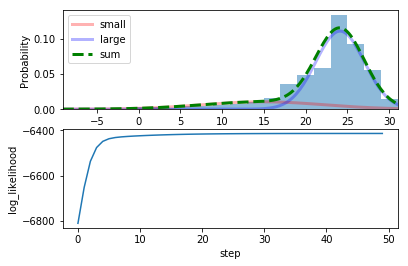

In [8]:
#mu, vs, pの初期値を設定する
p = 0.5
ms = [random.choice(data2), random.choice(data2)]
vs = [np.var(data2), np.var(data2)]
T = 50  #反復回数
ls = []  #対数尤度関数の計算結果を保存

#EMアルゴリズム
for t in range(T):
    burden_rates = e_step(data2, ms, vs, p)
    ms, vs, p = m_step(data2, burden_rates)
    ls.append(calc_log_likelihood(data2, ms, vs, p))

print("mu1 : ", ms[0])
print("v1 : ", ms[1])
print("v2 : ", vs[0])
print("p : ", vs[1])

plt.subplot(211)
xs = np.linspace(min(data2), max(data2), 200)
norm1 = scipy.stats.norm.pdf(xs, ms[0], math.sqrt(vs[0]))
norm2 = scipy.stats.norm.pdf(xs, ms[1], math.sqrt(vs[1]))
plt.hist(data2, bins=20, normed=True, alpha=0.5) # density or normed

plt.plot(xs, (1 - p) * norm1, color="red", lw=3, alpha=0.3)
plt.plot(xs, p * norm2, color="blue", lw=3, alpha=0.3)
plt.plot(
    xs, (1 - p) * norm1 + p * norm2, color="green", lw=3, linestyle='dashed')

plt.xlim(min(data2), max(data2))
plt.xlabel("x")
plt.ylabel("Probability")
plt.legend(["small", "large", "sum"])

plt.subplot(212)
plt.plot(np.arange(len(ls)), ls)
plt.xlabel("step")
plt.ylabel("log_likelihood")
plt.show()

ここでは少数派の裾の広い山(small)を異常と扱い、wbgt=18以上を正常とする

## separate small and large

In [9]:
# data 
# 2017_normal (4data with wbgt)_ @nagoya
# N = 1891

df7nw_cut = df7nw[df7nw.wbgt>18] 
df7nw_cut.describe()

,temp,wind_speed,solar_radiation,relative_humidity,wbgt
count,1891.000000,1891.000000,1891.000000,1891.000000,1891.000000
mean,26.613273,2.714225,0.486388,72.182972,24.116910
std,3.053120,1.585811,0.678913,13.745739,2.838067
min,18.200000,0.100000,0.000000,29.000000,18.004528
25%,24.700000,1.600000,0.000000,62.000000,22.302963
50%,26.600000,2.400000,0.040000,73.000000,24.388954
75%,28.500000,3.500000,0.880000,83.000000,25.972860
max,34.800000,15.400000,2.450000,96.000000,31.010760


## plot normal data (temp & humidity)

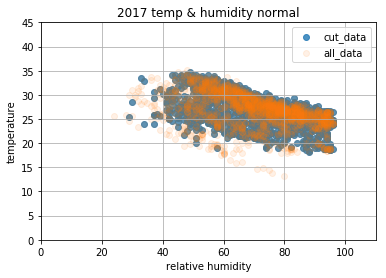

In [10]:
# 正常値を２次元（気温、湿度）でプロット

# normal label
y = np.array([0] * 1891)

# cut data = normal data
plt.scatter(df7nw_cut["relative_humidity"], df7nw_cut["temp"], alpha=0.8)

# all data
plt.scatter(df7n["relative_humidity"], df7n["temp"], alpha=0.1)

plt.title("2017 temp & humidity normal")
plt.grid()
plt.xlim([0, 110])
plt.ylim([0, 45])
plt.legend(['cut_data', 'all_data'])
plt.xlabel("relative humidity")
plt.ylabel("temperature")

plt.show()

In [11]:
# data 
# 2017_normal (humidity , temp)_ @nagoya

muhat = df7nw_cut[["relative_humidity", "temp"]].mean().values
X = df7nw_cut[["relative_humidity", "temp"]].values

In [12]:
li = 0
for i in range(1891):
    li += np.dot((X[i, :] - muhat).reshape(2, 1), (X[i, :] - muhat).reshape(
        1, 2))
sigmahat = li / 1891

for i in range(muhat.size):
    print('muhat ', i, ' : ', muhat[i])
print()
for i, item in np.ndenumerate(sigmahat):
    print('musigma ', i, ' : ', item)


muhat  0  :  72.18297197250132
muhat  1  :  26.613273400317357

musigma  (0, 0)  :  188.845421310161
musigma  (0, 1)  :  -21.246056370444066
musigma  (1, 0)  :  -21.246056370444066
musigma  (1, 1)  :  9.316613875014294


## plot contour

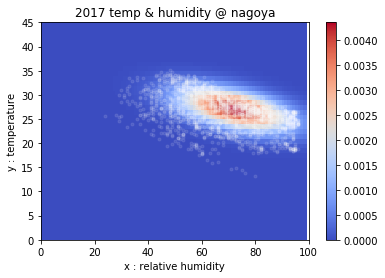

In [13]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from pylab import *  #コンタ描画用


def f(x, y):
    det = np.linalg.det(sigma)
    if det < 0:
        sys.exit()
    inv_sigma = np.linalg.inv(sigma)
    x_c = np.array([x, y]) - mu

    return 1 / (2 * np.pi * np.sqrt(det)) * np.exp(
        -x_c.dot(inv_sigma).dot(x_c.T) / 2.0)


x = y = np.arange(0, 100, 1)

X, Y = np.meshgrid(x, y)

mu = muhat
sigma = sigmahat
Z = np.vectorize(f)(X, Y)

plt.pcolor(X, Y, Z, cmap=cm.coolwarm)
plt.colorbar()

plt.xlim([0, 100])
plt.ylim([0, 45])

plt.xlabel("x : relative humidity")
plt.ylabel("y : temperature")

# 2017_normal (humidity , temp)_ @nagoya
plt.plot(
    df7n["relative_humidity"],
    df7n["temp"],
    ls="",
    marker="o",
    color="white",
    alpha=0.1,
    markersize=3)
plt.title("2017 temp & humidity @ nagoya")
plt.show()

# 近傍法
（入力のみ　＆　時系列＋時系列以外）

• k近傍法は、一般的に、教師あり学習アルゴリズムとして用いられる

• 教師ありアルゴリズムとしてのk近傍法

• 新しい観測点が得られたら、それを中心としてk個の既知データを含む円を描く

• 回帰問題であればそれらの平均(分類問題であれば最頻ラベル)を計算し、その結 果を新しい観測点の予測値にする

## k基準

* 𝑘基準
    * なんらかの方法で適切な$𝜀$を決める
    * 近傍数の閾値$𝑘_{𝑡ℎ}$を決める
    * 新たな観測値$𝑥′$に対して、半径𝜀の範囲に入る標本を$𝐷$から選ぶ
    * その標本の数𝑘が閾値$𝑘_{𝑡ℎ}$を下回ったら$𝑥′$は異常であると判定する

In [108]:
# df7nw_cut = 2017_ normal (4data with wbgt) _ N = 1891_ @nagoya
# X = 2017_ normal (temp & humidity) _ N = 1891_ @nagoya

X= df7nw_cut[["relative_humidity","temp"]].values
y=[0]*1891

In [109]:
# df8nw = 2018 _ all (4data with wbgt) _ N = 2208 _ @nagoya
# X_new =  2018 _ all (emp & humidity) _ N = 2208 _ @nagoya -> 2208

df2018 = pd.read_excel('data/hot/zenkoku2018.xlsx', sheet_name='Sheet1')
df8n=df2018[df2018['place']=='nagoya']
ta = df8n["temp"]
ws = df8n["wind_speed"]
sr = df8n["solar_radiation"]
rh = df8n["relative_humidity"]

wbgt = 0.735 * ta + 0.0374 * rh + 0.00292 * ta * rh + 7.619 * sr - 4.557 * sr**2 - 0.0572 * ws - 4.064
wbgt = pd.DataFrame(wbgt, columns=["wbgt"])
df8nw = pd.concat([df7n,wbgt],axis=1)

X_new = np.zeros((2208,2))
for i in range(2208):
    X_new[i][0]=df8nw["relative_humidity"].iloc[i]
    X_new[i][1]=df8nw["temp"].iloc[i]

## 近傍数 kth=3

In [198]:
from sklearn.neighbors import RadiusNeighborsClassifier

epsilon = 5  #　半径
k_th = 3  # 閾値(近傍点の個数)

rneigh = RadiusNeighborsClassifier(radius=epsilon)
rneigh.fit(X , y)

RadiusNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, outlier_label=None, p=2, radius=5,
             weights='uniform')

In [199]:
#判定
j = 0
anomaly_idx_k1 = []
dist, ind = rneigh.radius_neighbors(X_new, radius=epsilon)
np.set_printoptions(precision=2)

for d in dist:
    j = j + 1
    if len(d) < k_th:
        anomaly_idx_k1.append(j)
        print("Anomaly No = ", j, " / Dist to Neigh = ",d)
        if j >= X_new.shape[0]-1:
            break
    else:
        pass

Anomaly No =  1550  / Dist to Neigh =  [1.8 4.6]
Anomaly No =  2080  / Dist to Neigh =  [0.   3.26]
Anomaly No =  2160  / Dist to Neigh =  [4.66 4.61]
Anomaly No =  2161  / Dist to Neigh =  []
Anomaly No =  2162  / Dist to Neigh =  [4.22 4.51]
Anomaly No =  2163  / Dist to Neigh =  [4.61 4.9 ]
Anomaly No =  2164  / Dist to Neigh =  []
Anomaly No =  2165  / Dist to Neigh =  []
Anomaly No =  2166  / Dist to Neigh =  []
Anomaly No =  2167  / Dist to Neigh =  []
Anomaly No =  2171  / Dist to Neigh =  [3.61 2.06]
Anomaly No =  2196  / Dist to Neigh =  [4.03 0.8 ]
Anomaly No =  2197  / Dist to Neigh =  []
Anomaly No =  2199  / Dist to Neigh =  [3.28 1.12]
Anomaly No =  2200  / Dist to Neigh =  [3.26 0.  ]


In [200]:
len(anomaly_idx_k1)

15

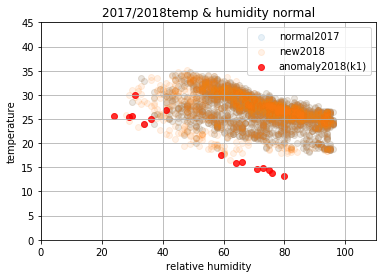

In [201]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.1)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.1)
plt.scatter(X_new[anomaly_idx_k1, 0], X_new[anomaly_idx_k1, 1], alpha=0.8,c='red')
plt.title("2017/2018temp & humidity normal")

plt.grid()
plt.xlim([0, 110])
plt.ylim([0, 45])
plt.legend(['normal2017','new2018','anomaly2018(k1)'])
plt.xlabel("relative humidity")
plt.ylabel("temperature")

plt.show()

## 近傍数 kth=10

In [202]:
from sklearn.neighbors import RadiusNeighborsClassifier

epsilon = 5  #　半径
k_th = 10  # 閾値(近傍点の個数)

rneigh = RadiusNeighborsClassifier(radius=epsilon)
rneigh.fit(X , y)

RadiusNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, outlier_label=None, p=2, radius=5,
             weights='uniform')

In [203]:
#判定
j = 0
anomaly_idx_k2=[]
dist, ind = rneigh.radius_neighbors(X_new, radius=epsilon)
np.set_printoptions(precision=2)

for d in dist:
    j = j + 1
    if len(d) < k_th:
        anomaly_idx_k2.append(j)
        print("Anomaly No = ", j, " / Dist to Neigh = ",d)
        if j >= X_new.shape[0]-1:
            break
    else:
        pass

Anomaly No =  156  / Dist to Neigh =  [1.5  4.53 1.35 4.21 4.72]
Anomaly No =  157  / Dist to Neigh =  [3.01 2.02 2.69 3.83 3.55 4.94]
Anomaly No =  159  / Dist to Neigh =  [3.01 2.15 3.16 4.32 3.84]
Anomaly No =  160  / Dist to Neigh =  [0.   1.17 4.88]
Anomaly No =  161  / Dist to Neigh =  [1.17 0.   3.72 4.53]
Anomaly No =  1500  / Dist to Neigh =  [3.2  3.45 2.79 4.02 4.08]
Anomaly No =  1501  / Dist to Neigh =  [2.88 2.97 2.9 ]
Anomaly No =  1502  / Dist to Neigh =  [3.78 2.6  4.35]
Anomaly No =  1503  / Dist to Neigh =  [2.24 3.52 2.44]
Anomaly No =  1548  / Dist to Neigh =  [4.71 4.01 4.9  4.   3.5  3.06 4.24 4.24 4.88]
Anomaly No =  1549  / Dist to Neigh =  [4.38 1.41 4.56 4.46]
Anomaly No =  1550  / Dist to Neigh =  [1.8 4.6]
Anomaly No =  1551  / Dist to Neigh =  [4.03 1.72 4.92 4.17]
Anomaly No =  2078  / Dist to Neigh =  [3.03 4.83 4.32 4.81 4.72 4.21 4.61 4.61]
Anomaly No =  2079  / Dist to Neigh =  [4.81 2.01 4.46 4.56]
Anomaly No =  2080  / Dist to Neigh =  [0.   3.26]
A

In [204]:
len(anomaly_idx_k2)

40

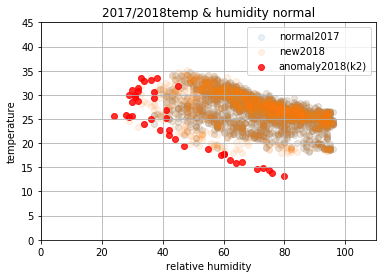

In [205]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.1)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.1)
plt.scatter(X_new[anomaly_idx_k2, 0], X_new[anomaly_idx_k2, 1], alpha=0.8,c='red')
plt.title("2017/2018temp & humidity normal")

plt.grid()
plt.xlim([0, 110])
plt.ylim([0, 45])
plt.legend(['normal2017','new2018','anomaly2018(k2)'])
plt.xlabel("relative humidity")
plt.ylabel("temperature")

plt.show()

近傍数の閾値をk=3からk=10に増加させると、異常と検出されるデータも15個から40個へ増加

## e基準

* 𝜀基準
    * なんらかの方法で適切な𝑘を決める
    * 半径の閾値$𝜀_{𝑡ℎ}$を決める
    * 新たな観測値$𝑥′$に対して、𝑘近傍となる標本を$𝐷$から選ぶ
    * それを取り囲む最小の半径$𝜀$を求める
    * それが閾値$𝜀_{𝑡ℎ}$を下回ったら$𝑥′$は異常であると判定する

## 半径 epsilon = 5

In [255]:
# 正常
from sklearn.neighbors import KNeighborsClassifier

k = 3 # 近傍点の個数
epsilon_th = 5 # 閾値(半径)

X= df7nw_cut[["relative_humidity","temp"]].values

kneigh = KNeighborsClassifier(n_neighbors=k)
kneigh.fit(X, y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [256]:
#判定
j = 0
anomaly_idx_e1=[]
dist, ind = kneigh.kneighbors(X_new)

for d in dist:
    j = j + 1
    r = np.max(d)
        
    if r > epsilon_th:
        anomaly_idx_e1.append(j)
        print("Anomaly No = ", j, " / Dist to Neigh = ",d)
        if j >= X_new.shape[0]-1:
            break
    else:
        pass

Anomaly No =  1550  / Dist to Neigh =  [1.8  4.6  5.25]
Anomaly No =  2080  / Dist to Neigh =  [0.   3.26 5.75]
Anomaly No =  2160  / Dist to Neigh =  [4.61 4.66 5.1 ]
Anomaly No =  2161  / Dist to Neigh =  [5.2  5.39 5.4 ]
Anomaly No =  2162  / Dist to Neigh =  [4.22 4.51 5.11]
Anomaly No =  2163  / Dist to Neigh =  [4.61 4.9  5.1 ]
Anomaly No =  2164  / Dist to Neigh =  [5.33 5.58 6.28]
Anomaly No =  2165  / Dist to Neigh =  [6.23 6.42 6.58]
Anomaly No =  2166  / Dist to Neigh =  [5.57 5.66 5.85]
Anomaly No =  2167  / Dist to Neigh =  [5.69 5.69 5.85]
Anomaly No =  2171  / Dist to Neigh =  [2.06 3.61 5.02]
Anomaly No =  2196  / Dist to Neigh =  [0.8  4.03 5.05]
Anomaly No =  2197  / Dist to Neigh =  [ 5.    6.66 10.14]
Anomaly No =  2199  / Dist to Neigh =  [1.12 3.28 6.32]
Anomaly No =  2200  / Dist to Neigh =  [0.   3.26 5.22]


In [257]:
len(anomaly_idx_e1)

15

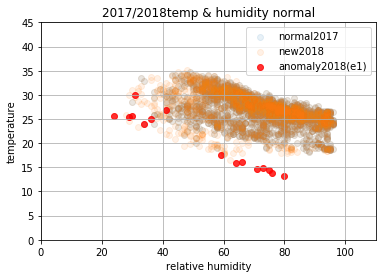

In [258]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.1)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.1)
plt.scatter(X_new[anomaly_idx_e1, 0], X_new[anomaly_idx_e1, 1], alpha=0.8,c='red')
plt.title("2017/2018temp & humidity normal")

plt.grid()
plt.xlim([0, 110])
plt.ylim([0, 45])
plt.legend(['normal2017','new2018','anomaly2018(e1)'])
plt.xlabel("relative humidity")
plt.ylabel("temperature")

plt.show()

## 半径 epsilon = 2

In [259]:
# 正常
from sklearn.neighbors import KNeighborsClassifier

k = 3 # 近傍点の個数
epsilon_th = 2 # 閾値(半径)

X= df7nw_cut[["relative_humidity","temp"]].values

kneigh = KNeighborsClassifier(n_neighbors=k)
kneigh.fit(X, y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [260]:
#判定

j = 0
anomaly_idx_e2=[]
dist, ind = kneigh.kneighbors(X_new)

for d in dist:
    j = j + 1
    r = np.max(d)
        
    if r > epsilon_th:
        anomaly_idx_e2.append(j)
        print("Anomaly No = ", j, " / Dist to Neigh = ",d)
        if j >= X_new.shape[0]-1:
            break
    else:
        pass

Anomaly No =  134  / Dist to Neigh =  [1.08 1.4  2.06]
Anomaly No =  136  / Dist to Neigh =  [0.   1.41 2.09]
Anomaly No =  156  / Dist to Neigh =  [1.35 1.5  4.21]
Anomaly No =  157  / Dist to Neigh =  [2.02 2.69 3.01]
Anomaly No =  158  / Dist to Neigh =  [2.42 2.97 3.77]
Anomaly No =  159  / Dist to Neigh =  [2.15 3.01 3.16]
Anomaly No =  160  / Dist to Neigh =  [0.   1.17 4.88]
Anomaly No =  161  / Dist to Neigh =  [0.   1.17 3.72]
Anomaly No =  1478  / Dist to Neigh =  [1.8  2.06 2.28]
Anomaly No =  1479  / Dist to Neigh =  [0.9  2.15 2.5 ]
Anomaly No =  1492  / Dist to Neigh =  [1.   1.64 2.15]
Anomaly No =  1493  / Dist to Neigh =  [1.2  1.8  2.09]
Anomaly No =  1494  / Dist to Neigh =  [1.   1.64 2.15]
Anomaly No =  1499  / Dist to Neigh =  [0.2  1.   2.56]
Anomaly No =  1500  / Dist to Neigh =  [2.79 3.2  3.45]
Anomaly No =  1501  / Dist to Neigh =  [2.88 2.9  2.97]
Anomaly No =  1502  / Dist to Neigh =  [2.6  3.78 4.35]
Anomaly No =  1503  / Dist to Neigh =  [2.24 2.44 3.52]


In [261]:
len(anomaly_idx_e2)

110

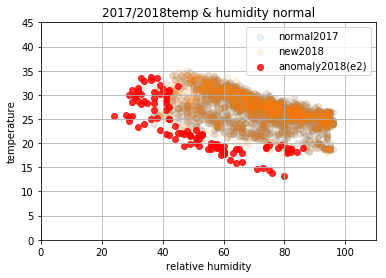

In [262]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.1)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.1)
plt.scatter(X_new[anomaly_idx_e2, 0], X_new[anomaly_idx_e2, 1], alpha=0.8,c='red')
plt.title("2017/2018temp & humidity normal")

plt.grid()
plt.xlim([0, 110])
plt.ylim([0, 45])
plt.legend(['normal2017','new2018','anomaly2018(e2)'])
plt.xlabel("relative humidity")
plt.ylabel("temperature")

plt.show()

半径がk=5からk=2に減少すると、異常と検出されるデータは15個から110個へ増加

# 局所外れ値度（LOF）
（入力のみ＆時系列以外）

局所外れ値度(local outliers factor, LOF)は、 近傍法の考え方を拡張した指標

LOFが大きいほど異常であると考える

$\displaystyle a_{LOF}(\boldsymbol{x}')=\frac{1}{k}\sum_{\boldsymbol{x}\in N_k(\boldsymbol{x}')} \frac{d_k(\boldsymbol{x}')}{d_k(\boldsymbol{x})}$  
$\boldsymbol{x}'$ : 観測点   
$a_{LOF}(\boldsymbol{x}')$ : 観測点$\boldsymbol{x}'$の異常度  
$d_k(\boldsymbol{x})$ : 近傍有効距離$l_k$を$\boldsymbol{x}$の周りの$k$近傍にわたり平均したもの  
$d_k(\boldsymbol{x}')$ : 近傍有効距離$l_k$を$\boldsymbol{x'}$の周りの$k$近傍にわたり平均したもの  


$d_k(\boldsymbol{x})$および$d_k(\boldsymbol{x}')$は、次のように定義される    
ここでは、$\boldsymbol{x}$または$\boldsymbol{x}'$を$\boldsymbol{u}$という記号で表現する  
$\displaystyle d_k(\boldsymbol{u})=\frac{1}{k}\sum_{\boldsymbol{u}' \in N_k(\boldsymbol{u})}l_k(\boldsymbol{u}\longrightarrow \boldsymbol{u}')$  
  

$ l_k(\boldsymbol{u}\longrightarrow \boldsymbol{u}') \equiv \
  \left\{
    \begin{array}{l}
      \epsilon_k(\boldsymbol{u}') ~~~~~~~(\boldsymbol{u}\in N_k(\boldsymbol{u}')かつ\boldsymbol{u}' \in N_k(\boldsymbol{u}))\\
      d(\boldsymbol{u}, \boldsymbol{u}')~ ~~~ (上記以外)
    \end{array}
  \right.
$

$d(\boldsymbol{u}, \boldsymbol{u}') $: ユークリッド距離など 
      
$ l_k(\boldsymbol{u}\longrightarrow \boldsymbol{u}')$ : $\boldsymbol{u}$から$\boldsymbol{u}'$への近傍有効距離  

In [263]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [264]:
def func_lof(X, k):
    clf = LocalOutlierFactor(n_neighbors=k)
    y_pred = clf.fit_predict(X)
    X_scores = clf.negative_outlier_factor_
    lof = -1 * clf.negative_outlier_factor_
    #   print("lof=%s"%lof)
    plt.title("Local Outlier Factor (LOF)")
    plt.scatter(X_new[:, 0], X_new[:, 1], color='k', s=3., label='Data points')

    # 0-1に正規化
    radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

    plt.scatter(
        X_new[:, 0],
        X_new[:, 1],
        s=1000 * radius,
        edgecolors='r',
        facecolors='none',
        label='Outlier scores')
    plt.axis('tight')
    plt.xlim([0, 110])
    plt.ylim([0, 45])
    legend = plt.legend(loc='upper left')
    legend.legendHandles[0]._sizes = [10]
    legend.legendHandles[1]._sizes = [20]
    plt.show()

    plt.plot(lof, marker="o")
    plt.ylabel("LOF")
    plt.xlabel("data ID")
    plt.show()
    return lof

## k=10

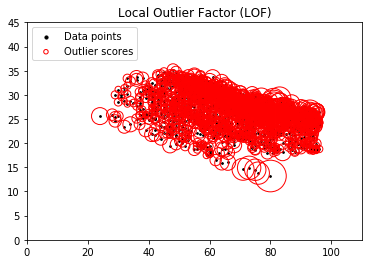

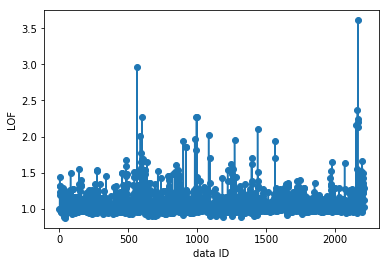

In [267]:
# X_new =  2018 _ all (emp & humidity) _ N = 2208 _ @nagoya

k = 10
X = np.r_[X_new]
lof = func_lof(X_new, k)

端のデータのLOFスコアは相対的に大きいことが確認できる

## k=1

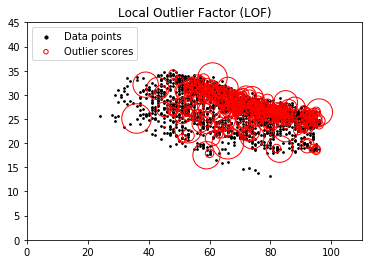

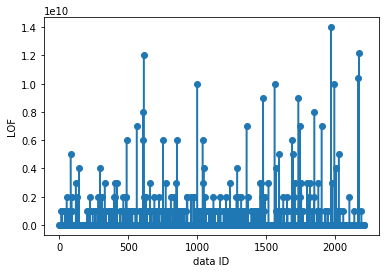

In [273]:
k = 1
X = np.r_[X_new]
lof = func_lof(X_new, k)

ただし、k=1の場合LOFが爆発した

# 1クラスSVM
（入力のみ＆時系列以外）

• 1クラスサポートベクトルマシン ： サポートベクトルの考え方を教師 なし学習に適応

• 異常検知などに利用される

• 1クラスサポートベクトルマシンには、大きくわけて2つの種類

  ①サポートベクトルデータ記述法 (support vector data desctiption, SVDD) 

    正常データを超球で包み、その半径を最適化する方法

  ②1クラスν-SVM

    1クラスν-SVMは、ν-SVMの考え方を教師なし学習に適応したもの

    原点を異常データの代表値とみなし、なるべく原点から離れる識別境界を探す

## 1クラス nu-SVM

In [274]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm
import seaborn as sns

In [275]:
# df8nw = 2018 _ all (4data with wbgt) _ N = 2208 _ @nagoya
# X_new =  2018 _ all (humidity&temp) _ N = 2208 _ @nagoya

df= []
df = pd.DataFrame({'relative_humidity':X_new.T[0],'temp': X_new.T[1]})

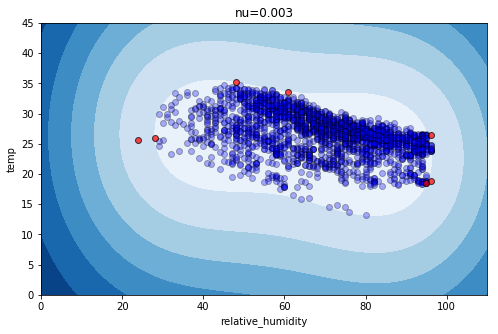

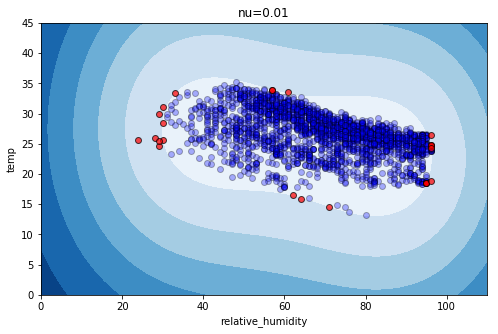

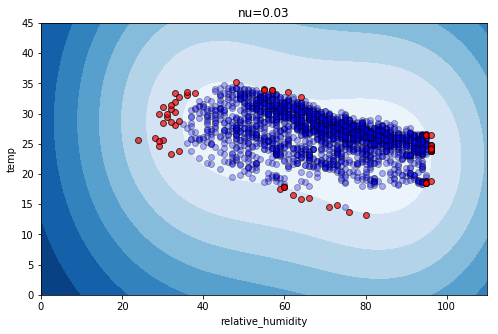

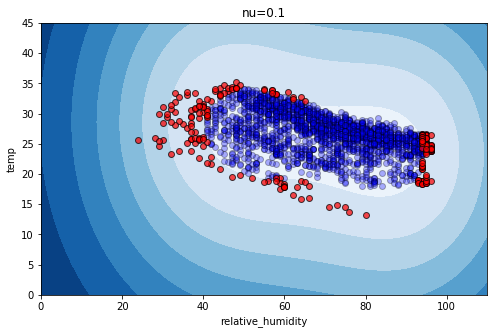

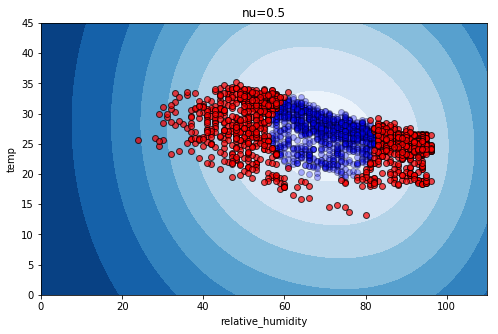

In [276]:

for nu in [0.003,0.01, 0.03,0.1, 0.5]:
    
    # 1クラスvu-SVMの実行
    clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=0.001)
    clf.fit(X_new)

    plt.figure(figsize=(8,5))
    xx, yy = np.meshgrid(np.linspace(0, 110, 100), np.linspace(0, 45, 100))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
    
        # 結果の描画
    df["y_pred"] = clf.predict(X_new)
    df_ = df[df["y_pred"]==1]
    plt.scatter(df_["relative_humidity"], df_["temp"], edgecolor='k',c="b",alpha=0.3)
    
    df_ =df[df["y_pred"]==-1]
    plt.scatter(df_["relative_humidity"], df_["temp"], edgecolor='k',c="r",alpha=0.7)
    
    plt.title("nu=%s"%nu)
    plt.xlim([0, 110])
    plt.ylim([0, 45])
    plt.xlabel("relative_humidity")
    plt.ylabel("temp")
    
    plt.show()

## SVDD

正常データを超球で包み、その半径を最適化する方法

usage
<pre>
    svm-train [options] training_set_file [model_file]
    options:
    
        -s svm_type : set type of SVM (default 0)  

                0 -- C-SVC		(multi-class classification)  
                1 -- nu-SVC		(multi-class classification)  
                2 -- one-class SVM  
                3 -- epsilon-SVR	(regression)  
                4 -- nu-SVR		(regression)  
                5 -- SVDD		(C should be between 1/num_instances and 1)  
                6 -- R^2: L1SVM  
                7 -- R^2: L2SVM  

        -t kernel_type  : set type of kernel function (default 2)  

                0 -- linear: u'*v  
                1 -- polynomial: (gamma*u'*v + coef0)^degree  
                2 -- radial basis function: exp(-gamma*|u-v|^2)  
                3 -- sigmoid: tanh(gamma*u'*v + coef0)  
                4 -- precomputed kernel (kernel values in training_set_file)  
        
        -d degree : set degree in kernel function (default 3)  
    
        -g gamma : set gamma in kernel function (default 1/num_features)  
    
        -r coef0 : set coef0 in kernel function (default 0)  

        -c cost : set the parameter C of -s 0, 3, 4, 5 and 7  
            (default 1, except 2/num_instances for -s 5)  

        -n nu : set the parameter nu of nu-SVC, one-class SVM, and nu-SVR
            (default 0.5)  

        -p epsilon : set the epsilon in loss function of epsilon-SVR  
            (default 0.1)  

        -m cachesize : set cache memory size in MB (default 100)  

        -e epsilon : set tolerance of termination criterion (default 0.001)  

        -h shrinking : whether to use the shrinking heuristics, 0 or 1 (default 1)  

        -b probability_estimates :   
            whether to train a SVC or SVR model for probability estimates, 0 or 1
            (default 0)  

        -wi weight : set the parameter C of class i to weight*C, for C-SVC   
            (default 1)  

        -v n: n-fold cross validation mode

        -q : quiet mode (no outputs)
</pre>

https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/#libsvm_for_svdd_and_finding_the_smallest_sphere_containing_all_data

In [277]:
import sys
sys.path.append('/Users/peasucrivafie/Documents/python/libsvm-3.22/python')
sys.path.append('/Users/yk131/iCloudDrive/Documents/python/libsvm-3.22/python')
from svm import *
from svmutil import *

In [278]:
libsvm

<CDLL '/Users/peasucrivafie/Documents/python/libsvm-3.22/python/../libsvm.so.2', handle 7f97e13903a0 at 0x1c21954a90>

In [279]:
#　test data

from svm import *
from svmutil import *

# For learning
t_label = [1, -1, 1, -1]
t_data = [[1.0, 2.0, 3.0], [3.0, 1.5, 1.0], [2.0, 3.0, 4.0], [0.5, 1.0, 1.5]]

problem = svm_problem(t_label, t_data)
parameter = svm_parameter('-s 5')
t = svm_train(problem, parameter)

optimization finished, 

#iter = 9
R^2 = 0.652208
obj = -0.326114, rho = -0.152218
nSV = 4, nBSV = 0　　

In [280]:
# For predict
p_label = [1, 1, -1, -1]
p_data = [[0.3, 0.9, 1.2], [2.0, 3.0, 4.5], [3.0, 1.0, 0.3], [1.0, 0.5, 0.25]]
result = svm_predict(p_label, p_data, t)

for r in result:
    print(r)

Accuracy = 50% (2/4) (classification)
[-1.0, -1.0, -1.0, -1.0]
(50.0, 2.0, nan)
[[0.0798614684716501], [0.09305866854825989], [0.1705116804259582], [0.31939999324071633]]


In [281]:
X= df7nw_cut[["relative_humidity","temp"]].values
y=[-1]*1891

X_=X.tolist()

In [282]:
# For learning

prob=svm_problem(y,X_)
parameter = svm_parameter('-s 5')  # SVDD ,d=3, rbf
t = svm_train(prob, parameter)

optimization finished, 

#iter = 387
R^2 = 0.991770
obj = -0.495831, rho = -0.491716
nSV = 329, nBSV = 0

In [283]:
# For predict
Xp = [[100,30],[50,10]]
yp = [1,-1]

In [285]:
result = svm_predict(yp, Xp, t)

Accuracy = 50% (1/2) (classification)


SVDDの  
+ 正常データ、超球、サポートベクトルの可視化
+ 手法の評価  
をやりたいが。。。

# 主成分分析
（入力のみ＆時系列以外）

• 元の変数に重みをかけた新しい合成変数(主成分)に よって、次元軸を減らす手法

• データの次元削減や、データの特性を抽出するのに役立つ

• 多次元データを低次元(2次元のグラフなど)で可視化できる

## 異常度の定義
$\displaystyle a({\boldsymbol x}')=||{\boldsymbol x}'_{(1)}||^2=||{\boldsymbol x}' - {\boldsymbol x}'_{(2)}||^2$  
${\boldsymbol x}'_{(2)}=U_m{U_m}^{T}{\boldsymbol x}'$  

${\boldsymbol x}'$ : 異常度を算出したい点  
${\boldsymbol x}'_{(1)}$ : 正常部分空間からはみ出る成分  
${\boldsymbol x}'_{(2)}$ : 正常部分空間の成分  
$U_m$ : 主成分ベクトルを列方向に並べた行列  
$m$ : 採用した主成分ベクトルの本数

In [286]:
from sklearn.decomposition import PCA

## data 2017w_all (4data with wbgt)_ @all pref

In [287]:
df2017 = pd.read_excel('data/hot/zenkoku2017.xlsx', sheet_name='Sheet1')

ta = df2017["temp"]
ws = df2017["wind_speed"]
sr = df2017["solar_radiation"]
rh = df2017["relative_humidity"]

wbgt = 0.735 * ta + 0.0374 * rh + 0.00292 * ta * rh + 7.619 * sr - 4.557 * sr**2 - 0.0572 * ws - 4.064
wbgt = pd.DataFrame(wbgt, columns=["wbgt"])
df2017w = pd.concat([df2017, wbgt], axis=1)

In [288]:
# place,time,nan を除去
df2017_5w = df2017w.drop(["place","time"],axis=1)
df2017_5w=df2017_5w.dropna()

In [289]:
df2017_5w.describe()

,temp,wind_speed,solar_radiation,relative_humidity,wbgt
count,74996.000000,74996.000000,74996.000000,74996.000000,74996.000000
mean,25.594229,2.653202,0.690898,76.035335,21.832106
std,4.173223,1.696671,0.970908,14.212921,5.998822
min,4.900000,0.000000,0.000000,22.000000,-12.419997
25%,22.800000,1.400000,0.000000,66.000000,19.460670
50%,25.900000,2.300000,0.100000,77.000000,23.238733
75%,28.500000,3.500000,1.180000,87.000000,25.814603
max,37.000000,17.600000,3.920000,100.000000,32.451030


In [290]:
# 散布行列の固有値を計算し、累積寄与度を確認

pca = PCA(n_components=5)
pca.fit(df2017_5w)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

## plot principal component

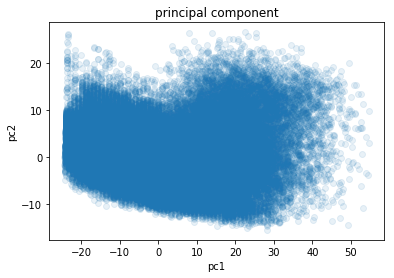

各次元の寄与率: [0.82 0.14 0.04 0.01 0.  ]
累積寄与率: 0.9999999999999999


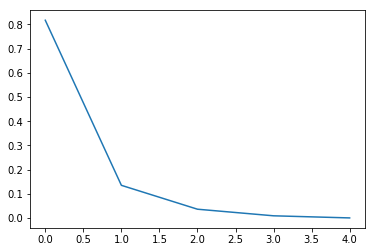

In [291]:
# 分析結果を元にデータセットを主成分に変換する

transformed = pca.fit_transform(df2017_5w)

# 主成分をプロットする
plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.1)

plt.title('principal component')
plt.xlabel('pc1')
plt.ylabel('pc2')

# グラフを表示する
plt.show()

# 主成分の寄与率を出力する
print('各次元の寄与率: {0}'.format(pca.explained_variance_ratio_))
print('累積寄与率: {0}'.format(sum(pca.explained_variance_ratio_)))

plt.plot(pca.explained_variance_ratio_)

# グラフを表示する
plt.show()

## plot temp & humidity

(0, 45)

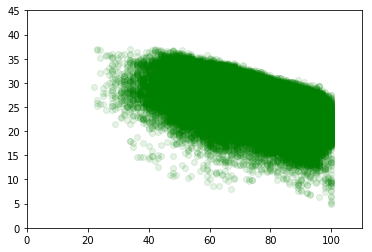

In [292]:
plt.scatter(df2017_5w['relative_humidity'],df2017_5w['temp'],alpha=0.1,color='g')
plt.xlim([0,110])
plt.ylim([0,45])

## 主成分分析を用いて、新しい第1主成分軸と第2主成分軸に射影

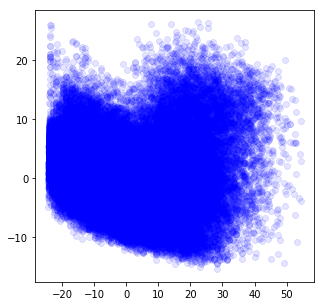

In [293]:
pca = PCA(n_components=2)
pca.fit(df2017_5w)

X_dash = pca.transform(df2017_5w)

plt.figure(figsize=(5, 5))
plt.scatter(X_dash[:, 0], X_dash[:, 1], marker="o", c="b", alpha=0.1)

# plt.xlim([-50, 70])
# plt.ylim([-20, 30])
plt.show()

## 正常部分空間の成分である${\boldsymbol x}'_{(2)}$を求める

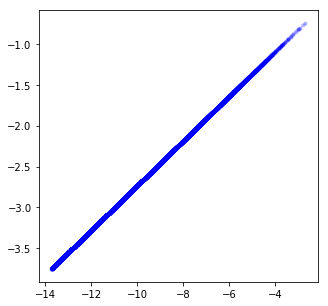

In [294]:
pca = PCA(n_components=1)
pca.fit(df2017_5w)

# 主成分ベクトル
U = pca.components_.T

# 正常部分空間の成分
X_2_n = np.dot(U, np.dot(U.T, df2017_5w.T)).T

plt.figure(figsize=(5,5))
plt.scatter(X_2_n[:,0], X_2_n[:,1], marker=".", c="b",alpha=0.1)

plt.show()

## 正常部分空間からはみ出る成分である${\boldsymbol x}'_{(1)}$を求める

In [295]:
X_1_n =  df2017_5w - X_2_n

## 異常度

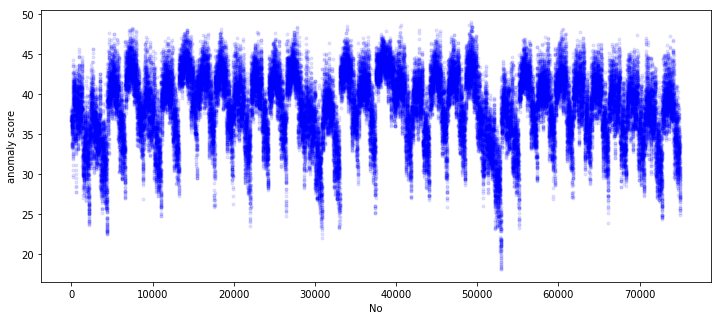

In [296]:
ascore_n = np.linalg.norm(X_1_n, axis=1)

plt.figure(figsize=(12, 5))
plt.plot(ascore_n, marker=".", c="b", ls="", alpha=0.1)

plt.ylabel("anomaly score")
plt.xlabel("No")
plt.show()

In [297]:
df2017.iloc[ascore_n.argsort()].head()

,place,time,temp,wind_speed,solar_radiation,relative_humidity
52885,sapporo,2017/9/26 14:00:00,23.6,5.5,2.20,32.0
52886,sapporo,2017/9/26 15:00:00,23.0,5.4,1.50,31.0
52887,sapporo,2017/9/26 16:00:00,22.3,3.0,1.02,38.0
52888,sapporo,2017/9/26 17:00:00,21.2,1.3,0.28,42.0
52883,sapporo,2017/9/26 12:00:00,22.7,2.8,2.72,38.0


In [298]:
df2017.iloc[ascore_n.argsort()].tail()

,place,time,temp,wind_speed,solar_radiation,relative_humidity
33898,nagasaki,2017/8/2 11:00:00,32.8,2.9,2.98,55.0
49040,saga,2017/7/20 9:00:00,28.5,1.5,0.57,81.0
40569,nara,2017/8/4 10:00:00,28.3,3.8,1.45,74.0
49256,saga,2017/7/29 9:00:00,29.6,0.7,1.67,77.0
49280,saga,2017/7/30 9:00:00,30.2,1.8,1.71,72.0


北海道が異常と検出

# 密度比推定
（入力のみ＆時系列以外）

uLSIF (unconstrained Least-Squares Importance Fitting) 

In [299]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from numpy import random
from numpy import linspace
from scipy.stats import norm
from densratio import densratio
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [300]:
# new data 2018 -> temp only

df2018 = pd.read_excel('data/hot/zenkoku2018.xlsx', sheet_name='Sheet1')
df8n=df2018[df2018['place']=='nagoya']
df8n_temp = df8n.temp[0:100]

In [322]:
# EM法で分離した nagoya 2017 data を正常データとして扱う -> temp only

X = df7nw_cut[["relative_humidity", "temp"]].values
df_temp=pd.DataFrame(X.T[1])

/Users/peasucrivafie/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


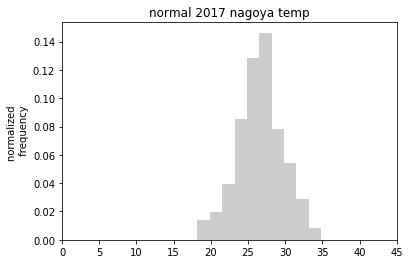

In [324]:
sns.distplot(df_temp, kde=False, norm_hist=True, bins=10, color="gray")
plt.title("normal 2017 nagoya temp")
plt.xlim([0, 45])
#plt.ylim([0, 0.5])
plt.ylabel("normalized \n frequency")
plt.show()

/Users/peasucrivafie/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


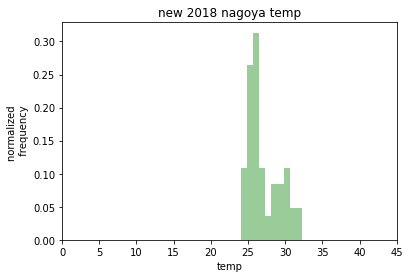

In [326]:
# 異常を含む可能性のある新しく観測されたデータ 100 point

sns.distplot(df8n_temp, kde=False, norm_hist=True, bins=10,color="green")
plt.title("new 2018 nagoya temp")
plt.xlim([0,45])
plt.ylabel("normalized \n frequency")
plt.show()

In [327]:
x1 = np.array((df_temp - df_temp.mean(axis=0)) / df_temp.std(axis=0))
x2 = np.array((df8n_temp -df8n_temp.mean(axis=0)) / df8n_temp.std(axis=0))
x1 = x1[:1891]
x2 = x2[:1891]

/Users/peasucrivafie/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


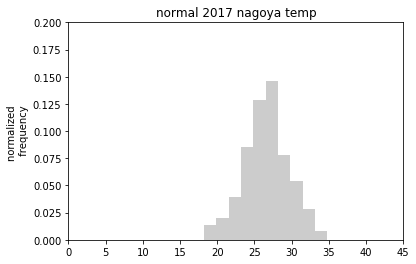

In [328]:
# 正常のみのデータ

sns.distplot(df_temp, kde=False, norm_hist=True, bins=10, color="gray")
plt.title("normal 2017 nagoya temp")
plt.xlim([0, 45])
plt.ylim([0, 0.2])
# plt.xlabel("temp[deg]")
plt.ylabel("normalized \n frequency")
plt.show()

/Users/peasucrivafie/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


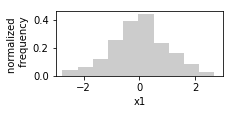

/Users/peasucrivafie/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


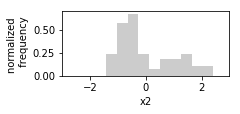

In [329]:
plt.figure(figsize=(3,1.2))
sns.distplot(x1, kde=False, norm_hist=True, bins=10,color="gray")
plt.xlabel("x1")
plt.xlim([-3,3])
plt.ylabel("normalized \n frequency")
plt.show()

plt.figure(figsize=(3,1.2))
sns.distplot(x2, kde=False, norm_hist=True, bins=10,color="gray")
plt.xlabel("x2")
plt.xlim([-3,3])
plt.ylabel("normalized \n frequency")
plt.show()

In [330]:
# 密度比推定を実行
result = densratio(x1,x2)
print(result)

################## Start uLSIF ##################
Searching optimal sigma and lambda...
  sigma = 0.001, lambda = 0.001, score = -14.836
Found optimal sigma = 0.001, lambda = 0.001.
Optimizing alpha...
End.
################## Finished uLSIF ###############
Method: uLSIF

Kernel Information:
  Kernel type: Gaussian RBF
  Number of kernels: 100
  Bandwidth(sigma): 0.001
  Centers: matrix([[-0.92],..

Kernel Weights(alpha):
  array([ 7.4 , 7.93, 5.29, 7.93, 4.76, 10.58, 3.7 , 4.76, 17.45,..

Regularization Parameter(lambda): 0.001

The Function to Estimate Density Ratio:
  compute_density_ratio(x)


In [331]:
display(len(x1))
display(len(x2))

1891

100

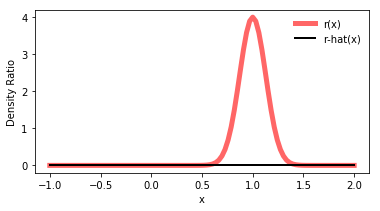

In [332]:
def true_density_ratio(x):
    """
    正解の密度比を算出する
    """
    return norm.pdf(x, 1, 1./8) / norm.pdf(x, 1, 1./2)

def estimated_density_ratio(x):
    """
    推定した密度比を取り出す
    """
    return result.compute_density_ratio(x)

x = linspace(-1, 2, 100)
plt.figure(figsize=(6,3))
plt.plot(x, true_density_ratio(x), "r-", lw=5, alpha=0.6, label="r(x)")
plt.plot(x, estimated_density_ratio(x), "k-", lw=2, label="r-hat(x)")
plt.legend(loc="best", frameon=False)
plt.xlabel("x")
plt.ylabel("Density Ratio")
plt.show()

→結果?

# アイソレーションフォレスト
（入力のみ＆時系列以外）

In [333]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

## データ生成

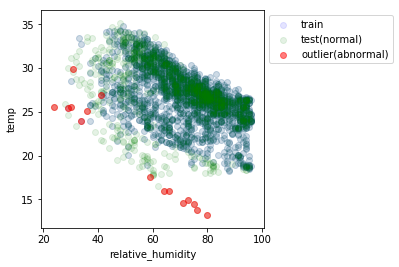

In [335]:
# rng = np.random.RandomState(42)

# 学習用データ
X_train = df7nw_cut[["relative_humidity","temp"]].values

# テスト用データ(正常)
X_test = X_new

# テスト用　データ(異常)
X_outliers = X_new[anomaly_idx_k1]

plt.figure(figsize=(4,4))
plt.scatter(X_train[:,0],X_train[:,1], c="b",alpha=0.1)
plt.scatter(X_test[:,0],X_test[:,1], c="g",alpha=0.1)
plt.scatter(X_outliers[:,0],X_outliers[:,1], c="r",alpha=0.5)

plt.xlabel("relative_humidity")
plt.ylabel("temp")
plt.legend(["train","test(normal)","outlier(abnormal)"], bbox_to_anchor=[1,1])

## 学習

In [336]:
# fit the model
# rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=None)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

## 結果の描画

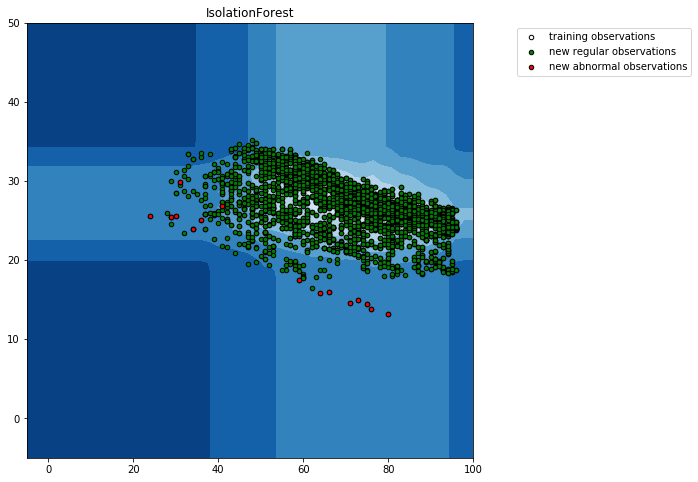

In [337]:
# 決定境界の描画
xx, yy = np.meshgrid(np.linspace(-5, 100, 50), np.linspace(-5, 50, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,8))
plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

# 観測点の描画
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
          bbox_to_anchor=[1.5,1])
plt.show()

## 各点の異常度を求める

In [338]:
print('train : ', clf.decision_function(X_train).shape)
print('test : ', clf.decision_function(X_test).shape)
print('outliers : ', clf.decision_function(X_outliers).shape)

train :  (1891,)
test :  (2208,)
outliers :  (15,)


In [340]:
print('train : ', clf.decision_function(X_train))
print('test : ', clf.decision_function(X_test))
print('outliers : ', clf.decision_function(X_outliers))

train :  [-0.03 -0.02 -0.04 ... -0.11 -0.09 -0.1 ]
test :  [-0.03 -0.02 -0.04 ... -0.12 -0.12 -0.1 ]
outliers :  [-0.11 -0.08 -0.1  -0.09 -0.09 -0.1  -0.09 -0.09 -0.1  -0.11 -0.1  -0.09
 -0.09 -0.09 -0.1 ]
